# Matrix Decompositions

In [115]:
import logging
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition
from sklearn import cluster

In [25]:
#Setting random seed
rng = np.random.seed(42)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

#Global Centering(focus on one feature, centering all faces)
faces_centered = faces - faces.mean(axis=0)

#Local Centering(focus on one sample,centering all faces)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print(f"Dataset consists of {n_samples} faces")

Dataset consists of 400 faces


In [101]:
n_row, n_col = 2, 3
n_components = n_row*n_col
image_shape = (64,64)

def plot_gallery(title, images, n_row=n_row, n_col=n_col, cmap="gray"):
    
    
    fig, axs = plt.subplots(
        nrows=n_row, 
        ncols=n_col, 
        figsize=(2*n_col, 3*n_row), 
        facecolor="lightgray", 
        constrained_layout=True)
    
    #For managing the spacing between each subplots and the overall plt
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=14)
    
    for ax, vec in zip(axs.flat, images):
        
        #For the range of colorbar
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            vmin=-vmax,
            vmax=vmax,
            interpolation="nearest")
        ax.axis("off")
        
    
    #For adding colorbar to a plot
    fig.colorbar(im, ax=axs, orientation="horizontal")
    plt.show()

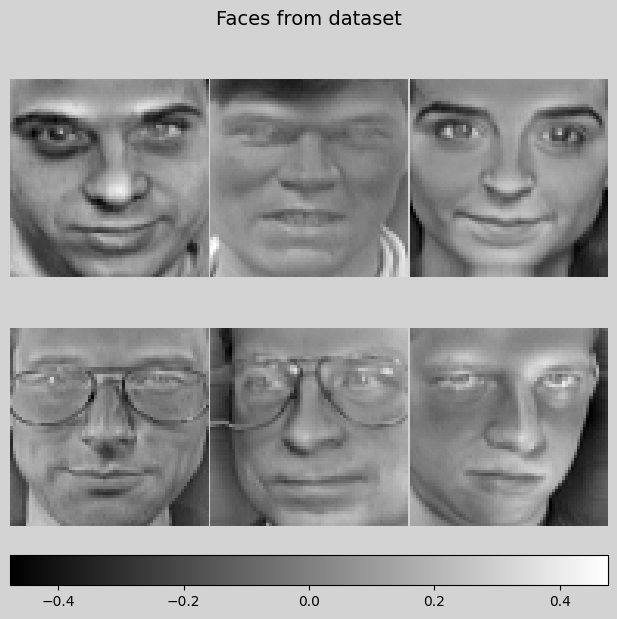

In [100]:
plot_gallery("Faces from dataset", faces_centered[5:5+n_components])

## Dictionary Learning

In [183]:
%%time
%%capture cap --no-stderr
batch_dl = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components, alpha=0.1, max_iter=50, batch_size=3, shuffle=True,verbose=True,random_state=rng)

batch_dl.fit(faces_centered)

CPU times: user 3.23 s, sys: 348 ms, total: 3.58 s
Wall time: 1.89 s


### Output File

In [184]:
#saving the logs to .txt file
with open("DictionaryLearning.txt", "w") as f:
    f.write(cap.stdout)

In [185]:
#Parsing .txt file 
with open("DictionaryLearning.txt", "r") as f:
    lines = f.readlines()

with open("DictionaryLearning.csv", "w") as f_:

    header = ["Minibatch step", "mean batch cost", "ewa cost"]
    writer = csv.DictWriter(f_, fieldnames=header)
    writer.writeheader()
    
    for line in lines[1:]:
        
        if not line.startswith("Converged"):
            line = line.lower()
            tokens = line.split(": ")
            step_info = tokens[0].split(" ")
            current_step, total_step = step_info[2].split("/")
            try:
                mean = float(tokens[2])
                mean = f"{mean:.2f}"
            except ValueError:
                mean = float(tokens[2].split(",")[0])
                mean = f"{mean:.2f}"
            ewa_mean = None
            if len(tokens) > 3:
                ewa_mean = float(tokens[3].strip())
                ewa_mean = f"{ewa_mean:.2f}"
            writer.writerow({"Minibatch step": current_step, "mean batch cost": mean, "ewa cost":ewa_mean})
    print(f"Successfully Stored as CSV\n")


Successfully Stored as CSV



### Metrics
1.  Mean batch cost: This is the average cost for a single batch of training data. In mini-batch learning, the data is divided into small batches, and the algorithm updates the model parameters after each batch is processed. The mean batch cost is the average cost across all the examples in a batch. Lower values of mean batch cost indicate better performance, as the algorithm is able to fit the data more accurately.
2. EWA(Exponentially weighted moving average) cost: This is a measure of the overall cost function that takes into account the previous cost values as well as the current one. The EWA cost gives more weight to recent cost values, and less weight to older ones, using a decaying exponential function. This means that the EWA cost is a smoothed version of the cost function, that captures the overall trend in the performance of the algorithm over time. Lower values of EWA cost indicate that the algorithm is improving over time.

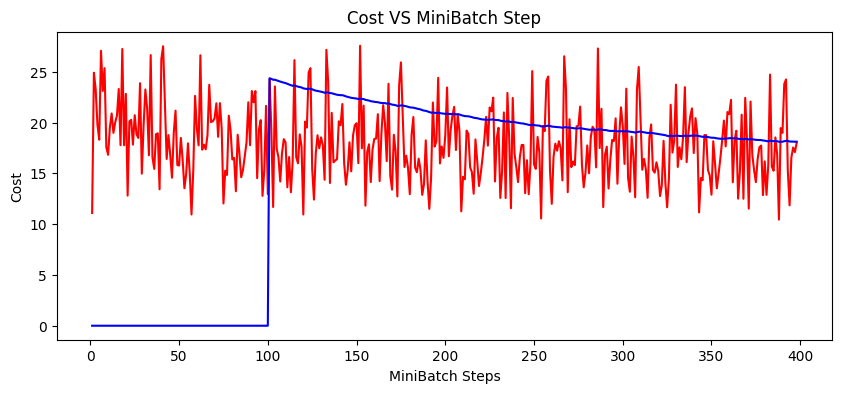

In [186]:
step = []
mean = []
ewa_mean = []
with open("DictionaryLearning.csv", "r") as f:
    reader = csv.DictReader(f)
    
    for line in reader:
        step.append(float(line["Minibatch step"]))
        mean.append(float(line["mean batch cost"]))
        try: 
            ewa_mean.append(float(line["ewa cost"]))
        except ValueError:
            ewa_mean.append(0)

plt.figure(figsize=(10,4))
plt.plot(step, mean, "r", label="Mean batch cost")
plt.plot(step, ewa_mean, "b", label="EWA cost")
plt.xlabel("MiniBatch Steps")
plt.ylabel("Cost")
plt.title("Cost VS MiniBatch Step")
plt.show()

In [187]:
print(max(mean), min(mean))

27.57 10.45


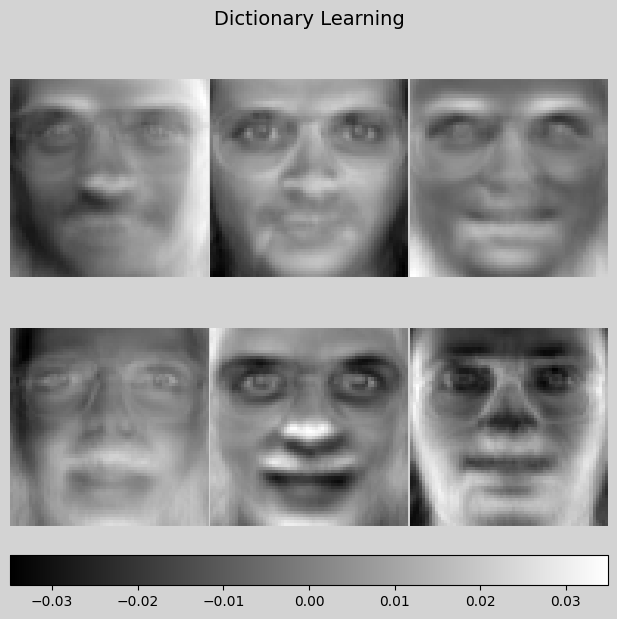

In [188]:
plot_gallery("Dictionary Learning", batch_dl.components_[:n_components])